In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
# Reading in TRAIN (df) and TEST (fd) data
df = pd.read_csv('./data/df.csv')
fd = pd.read_csv('./data/fd.csv')
# To facilitate Kaggle submissions
submission_index = list(range(1461,2920))
# For referncing feature names
cols = list(fd.columns.values)

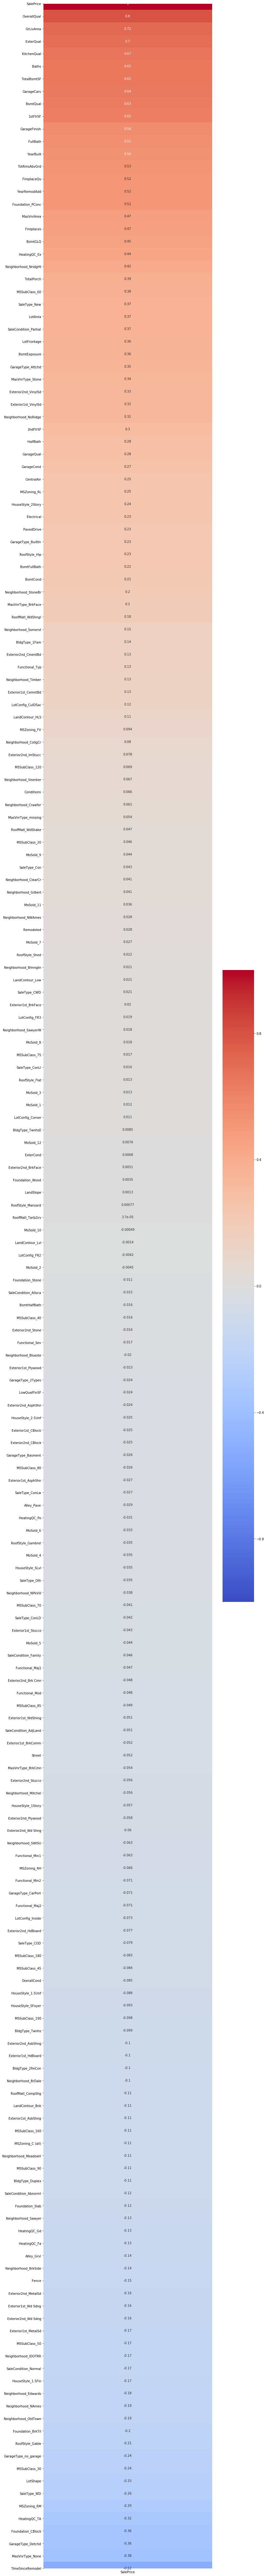

In [3]:
plt.figure(figsize=(12,150))
sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice',ascending=False),
            vmin=-1, annot=True, cmap='coolwarm');

# Preprocessing data

In [4]:
# Creating our feature matrix (X) and target array (y)
X = df.drop(columns=['SalePrice'], axis=1)
y = np.log(df['SalePrice'])

In [5]:
# Creating scaled version of X (X_sc) and fd (fd_sc)
ss = StandardScaler()
X_sc = ss.fit_transform(X)
fd_sc = ss.transform(fd)

# Creating train/test split for X_sc (X_train_sc, X_test_sc)
X_train, X_test, y_train, y_test = train_test_split(X_sc,
                                                    y,
                                                    random_state=42)

In [6]:
# Creating PCA transformed version of X (X_pca) and fd (fd_pca)
pca = PCA()
Z = pca.fit_transform(X_sc)
fd_pca = pca.transform(fd_sc)

# Creating train/test split for X_pca (Z_train_pca, Z_test_pca)
Z_train, Z_test, y_train, y_test = train_test_split(Z,
                                                    y,
                                                    random_state=42)

# Multiple Linear Regression
    - LASSO Regularization
    - Ridge Regularization
    - ElasticNet Regularization
    - LASSO Regression with Polynomial Features
    - Principal Component Analysis (PCA) Transformation

### LASSO Regression

In [7]:
# Instantiating the model
lasso = LassoCV(cv=5)

# Instantiating GridSearch to evaluate parameters for LASSO
lasso_gs = GridSearchCV(estimator=lasso,
                        param_grid={'eps':[0.01,0.001,0.0001],
                                    'n_alphas':[10,100,1000],
                                    'max_iter':[8000,10000]})
# Fitting GridSearch
lasso_gs.fit(X_train, y_train)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001,
                               fit_intercept=True, max_iter=1000, n_alphas=100,
                               n_jobs=None, normalize=False, positive=False,
                               precompute='auto', random_state=None,
                               selection='cyclic', tol=0.0001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'eps': [0.01, 0.001, 0.0001],
                         'max_iter': [8000, 10000],
                         'n_alphas': [10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [8]:
# Generating predictions based on best model evaluated by GridSearch
lasso_preds = (lasso_gs.best_estimator_).predict(X_test)


print(f'(LASSO) Mean cross-validation score: {round(lasso_gs.best_score_,4)}')
print(f'(LASSO) Root mean squared log error: {round(((y_test-lasso_preds)**2).mean()**(1/2),3)}')
print()
print(f'(LASSO) Best parameters, gridsearch: {lasso_gs.best_params_}')

(LASSO) Mean cross-validation score: 0.8933
(LASSO) Root mean squared log error: 0.105

(LASSO) Best parameters, gridsearch: {'eps': 0.0001, 'max_iter': 8000, 'n_alphas': 100}


In [9]:
# Instantiating LASSO model with best parameters identified by Gridsearch
lasso_model = LassoCV(eps=0.0001,
                      n_alphas=100,
                      max_iter=8000)

# Fitting LASSO model for submission
lasso_model.fit(X_sc, y)

# Generating predictions
lasso_preds = np.exp(lasso_model.predict(fd_sc))

# Creating DataFrame for exporting .csv
lasso_sub = pd.DataFrame(columns=['Id','SalePrice'])
lasso_sub['Id'] = submission_index
lasso_sub['SalePrice'] = lasso_preds

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [10]:
# Exporting high-value features for Decision Trees modeling
lasso_df = pd.DataFrame(columns=['Lasso_coef'])
lasso_df['Lasso_coef'] = lasso_model.coef_
lasso_df = lasso_df.T
lasso_df = lasso_df.rename(columns=lambda x: cols[x])
lasso_df = lasso_df.T
lasso_df = lasso_df[lasso_df['Lasso_coef']>abs(0.01)]
lasso_df

,Lasso_coef
LotArea,0.031852
OverallQual,0.074470
OverallCond,0.036483
YearBuilt,0.034641
BsmtQual,0.011203
BsmtExposure,0.012042
TotalBsmtSF,0.038940
CentralAir,0.013877
GrLivArea,0.102119
BsmtFullBath,0.012602


In [11]:
# Creating a list of high-value features
lasso_features = list(lasso_df.index.values)

# Creating DataFrame of high-value features, restoring label
df_select = df[lasso_features]
fd_select = fd[lasso_features]
df_select['SalePrice'] = df['SalePrice']

# Exporting to .csv
df_select.to_csv('./data/df_select_features.csv',
                 index=False)
fd_select.to_csv('./data/fd_select_features.csv',
                 index=False)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
# Exporting to .csv
lasso_sub.to_csv('./data/lasso_without_pca.csv',
                 index=False)

**Kaggle score:**\
RMSLE: 0.1632

### Ridge Regression

In [13]:
# Instantiating the model
ridge = RidgeCV(alphas=(0.01,0.1,1,10,100), cv=5)

# Fitting model
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), cv=5,
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [14]:
# Generating predictions
ridge_preds = ridge.predict(X_test)

print(f'(Ridge) Mean cross-validation score: {round(cross_val_score(ridge, X, y, cv=5).mean(),4)}')
print(f'(Ridge) Root mean squared log error: {round(((y_test-ridge_preds)**2).mean()**(1/2),3)}')
print()

(Ridge) Mean cross-validation score: 0.9026
(Ridge) Root mean squared log error: 0.111



In [15]:
# Fitting Ridge model for submission
ridge.fit(X_sc, y)

# Generating predictions for submission
ridge_preds = ridge.predict(fd_sc)

# Creating DataFrame for exporting .csv
ridge_without_pca = pd.DataFrame(columns=['Id','SalePrice'])
ridge_without_pca['Id'] = submission_index
ridge_without_pca['SalePrice'] = np.exp(ridge_preds)

In [16]:
ridge_without_pca.to_csv('./data/ridge_without_pca.csv',
                         index=False)

#### Kaggle score:
    - RMSLE: 0.1650

### ElasticNet Regression

In [43]:
# Instantiating ElasticNet Regression model
elastic = ElasticNetCV(verbose=1, n_jobs=4)
# Defining GridSearch parameter grid
elastic_params = {'l1_ratio':[.1,.5,.7,.9,.95, .99],
                  'eps':[0.001, 0.01],
                  'n_alphas':[80,100,120]}
# Instantiating GridSearch
elastic_gs = GridSearchCV(elastic,
                          param_grid=elastic_params,
                          cv=5,
                          verbose=1,
                          n_jobs=4)
# Fitting Gridsearch
elastic_gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   12.9s finished
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.1s finished
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNetCV(alphas=None, copy_X=True, cv='warn',
                                    eps=0.001, fit_intercept=True, l1_ratio=0.5,
                                    max_iter=1000, n_alphas=100, n_jobs=4,
                                    normalize=False, positive=False,
                                    precompute='auto', random_state=None,
                                    selection='cyclic', tol=0.0001, verbose=1),
             iid='warn', n_jobs=4,
             param_grid={'eps': [0.001, 0.01],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                         'n_alphas': [80, 100, 120]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [44]:
elastic_preds = (elastic_gs.best_estimator_).predict(X_test)

print(f'(Elast) Mean cross-validation score: {round(elastic_gs.best_score_,4)}')
print(f'(Elast) Root mean squared log error: {round(((y_test-elastic_preds)**2).mean()**(1/2),3)}')
print()
print(f'(Elast) Best parameters, gridsearch: {elastic_gs.best_params_}')

(Elast) Mean cross-validation score: 0.7876
(Elast) Root mean squared log error: 0.169

(Elast) Best parameters, gridsearch: {'eps': 0.001, 'l1_ratio': 0.99, 'n_alphas': 80}


In [54]:
# Instantiating model based on GridSearch parameters
elastic_net = ElasticNetCV(eps=0.001,
                           l1_ratio=0.99,
                           n_alphas=80)
# Fitting model on full training set for submission
elastic_net.fit(X_sc, y)

# Generating predictions
elastic_preds = elastic_net.predict(fd_sc)

# Creating DataFrame for exporting .csv
elastic_df = pd.DataFrame(columns=['Id','SalePrice'])
elastic_df['Id'] = submission_index
elastic_df['SalePrice'] = np.exp(elastic_preds)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [55]:
elastic_df.to_csv('./data/elastic.csv',index=False)

#### Kaggle score:
    - RMSLE: 0.1635

### LASSO Regression with Polynomial Features

In [17]:
# Creating DataFrames for polynomial features
df_poly = df[['OverallQual','ExterQual','KitchenQual','Baths','GarageCars','BsmtQual','TotRmsAbvGrd']]
fd_poly = fd[['OverallQual','ExterQual','KitchenQual','Baths','GarageCars','BsmtQual','TotRmsAbvGrd']]

# Transforming DataFrames using polynomial features
poly = PolynomialFeatures()
df_poly = poly.fit_transform(df_poly)
fd_poly = poly.fit_transform(fd_poly)

In [18]:
pd.DataFrame(fd_poly).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,5.0,1.0,1.0,1.0,1.0,2.0,5.0,25.0,5.0,...,1.00,1.0,2.0,5.0,1.0,2.0,5.0,4.0,10.0,25.0
1,1.0,6.0,1.0,2.0,1.5,1.0,2.0,6.0,36.0,6.0,...,2.25,1.5,3.0,9.0,1.0,2.0,6.0,4.0,12.0,36.0
2,1.0,5.0,1.0,1.0,2.5,2.0,3.0,6.0,25.0,5.0,...,6.25,5.0,7.5,15.0,4.0,6.0,12.0,9.0,18.0,36.0
3,1.0,6.0,1.0,2.0,2.5,2.0,2.0,7.0,36.0,6.0,...,6.25,5.0,5.0,17.5,4.0,4.0,14.0,4.0,14.0,49.0
4,1.0,8.0,2.0,2.0,2.0,2.0,3.0,5.0,64.0,16.0,...,4.00,4.0,6.0,10.0,4.0,6.0,10.0,9.0,15.0,25.0


In [19]:
# Instantiating features, target
X = df_poly
y = np.log(df['SalePrice'])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

# Instantiating GridSearch
lasso = LassoCV()
gs_poly = GridSearchCV(lasso,
                       param_grid={'eps':[0.01,0.001,0.0001],
                                    'n_alphas':[10,100,1000],
                                    'max_iter':[8000,10000]},
                       cv=5)

# Fitting GridSearch to data
gs_poly.fit(X_train, y_train)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explici

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explici

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explici

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
                               fit_intercept=True, max_iter=1000, n_alphas=100,
                               n_jobs=None, normalize=False, positive=False,
                               precompute='auto', random_state=None,
                               selection='cyclic', tol=0.0001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'eps': [0.01, 0.001, 0.0001],
                         'max_iter': [8000, 10000],
                         'n_alphas': [10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
# Generating predictions based on best model evaluated by GridSearch
poly_preds = (gs_poly.best_estimator_).predict(X_test)


print(f'(LASSO) Mean cross-validation score: {round(gs_poly.best_score_,4)}')
print(f'(LASSO) Root mean squared log error: {round(((y_test-poly_preds)**2).mean()**(1/2),3)}')
print()
print(f'(LASSO) Best parameters, gridsearch: {gs_poly.best_params_}')

(LASSO) Mean cross-validation score: 0.7973
(LASSO) Root mean squared log error: 0.169

(LASSO) Best parameters, gridsearch: {'eps': 0.0001, 'max_iter': 8000, 'n_alphas': 10}


In [25]:
# Instantiating LASSO model with best parameters identified by Gridsearch
poly_model = LassoCV(eps=0.0001,
                     n_alphas=10,
                     max_iter=8000)
# Fitting LASSO model for submission
poly_model.fit(X, y)

# Generating predictions
poly_preds = np.exp(poly_model.predict(fd_poly))

# Creating DataFrame for submission
poly_sub = pd.DataFrame(columns=['Id','SalePrice'])
poly_sub['Id'] = submission_index
poly_sub['SalePrice'] = poly_preds

# # Exporting to .csv
poly_sub.to_csv('./data/poly.csv', index=False)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


#### Kaggle score:
    - RMSLE: 0.1921

### LASSO Regression with PCA

In [27]:
i = 100
var_exp = pca.explained_variance_ratio_
print(f"Explained varience (first {i} components): {np.round(var_exp[:i],3)}")
print()
cum_var_exp = np.cumsum(var_exp)
print(f"Explained varience (first {i} components): {np.round(cum_var_exp[:i],3)[-1]}")

Explained varience (first 100 components): [0.079 0.035 0.031 0.025 0.021 0.02  0.018 0.016 0.015 0.014 0.013 0.013
 0.013 0.012 0.012 0.012 0.012 0.011 0.011 0.011 0.01  0.01  0.01  0.01
 0.01  0.01  0.009 0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.006 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006
 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004]

Explained varience (first 100 components): 0.871


In [31]:
# Instantiating the model
lasso = LassoCV()

# Instantiating GridSearch to evaluate parameters for LASSO
lasso_gs = GridSearchCV(estimator=lasso,
                        param_grid={'eps':[0.01,0.001,0.0001],
                                    'n_alphas':[10,100,1000]})
# Fitting GridSearch
lasso_gs.fit(Z_train, y_train)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explici

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
                               fit_intercept=True, max_iter=1000, n_alphas=100,
                               n_jobs=None, normalize=False, positive=False,
                               precompute='auto', random_state=None,
                               selection='cyclic', tol=0.0001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'eps': [0.01, 0.001, 0.0001],
                         'n_alphas': [10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
# Generating predictions based on best model evaluated by GridSearch
lasso_preds = (lasso_gs.best_estimator_).predict(Z_test)


print(f'(LASSO) Mean cross-validation score: {round(lasso_gs.best_score_,4)}')
print(f'(LASSO) Root mean squared log error: {round(((y_test-lasso_preds)**2).mean()**(1/2),3)}')
print()
print(f'(LASSO) Best parameters, gridsearch: {lasso_gs.best_params_}')

(LASSO) Mean cross-validation score: 0.8856
(LASSO) Root mean squared log error: 0.112

(LASSO) Best parameters, gridsearch: {'eps': 0.0001, 'n_alphas': 10}


In [35]:
# Instantiating model for submission
lasso = LassoCV(eps=0.0001,
                n_alphas=10)
# Fitting model on whole training set for submission
lasso.fit(Z, y)

# Generating predictions for submission
lasso_preds = lasso.predict(fd_pca)

# Creating DataFrame for submission
lasso_pca = pd.DataFrame(columns=['Id','SalePrice'])
lasso_pca['Id'] = submission_index
lasso_pca['SalePrice'] = np.exp(lasso_preds)

/Users/mikhaillenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [36]:
lasso_pca.to_csv('./data/lasso_pca.csv',
                 index=False)

#### Kaggle score:
    - RMSLE: 0.1637

## Ridge Regression with PCA

In [ ]:
ridge = RidgeCV(alphas=(0.001,0.01,0.1,1,10,100,1000), cv=5)

ridge.fit(Z_train, y_train)

In [ ]:
# Generating predictions
ridge_preds = ridge.predict(Z_test)

print(f'(Ridge) Mean cross-validation score: {round(cross_val_score(ridge, Z, y, cv=5).mean(),4)}')
print(f'(Ridge) Root mean squared log error: {round(((y_test-ridge_preds)**2).mean()**(1/2),4)}')

In [ ]:
# Fitting model for submission
ridge.fit(Z, y)

# Generating predictions for submission
ridge_preds = np.exp(ridge.predict(fd_pca))

# Creating DataFrame for submission
ridge_pca = pd.DataFrame(columns=['Id','SalePrice'])
ridge_pca['Id'] = submission_index
ridge_pca['SalePrice'] = ridge_preds

In [ ]:
# Exporting to .csv
ridge_pca.to_csv('./data/ridge_pca.csv', index=False)

#### Kaggle score:
    - RMSLE: 0.1650